In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import spectrogram, cwt, ricker

In [3]:
erp_mat = loadmat('ERP_data.mat')
erp_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [4]:
trials = erp_mat['EEGData'].shape[2]
dlength = erp_mat['EEGData'].shape[0]
erp_arr = np.zeros([trials, dlength])

for t in range(trials):
    erp_arr[t, :] = erp_mat['EEGData'][:, 0, t]

erp = np.mean(erp_arr, axis=0)

erp_fs = 512 # 1 / np.diff(erp_mat['EEGTime'].ravel())[0]
erp_N = erp.shape[0]
erp_time = erp_mat['EEGTime'].ravel() # np.linspace(0, erp_N / fs, erp_N, endpoint=False)

In [5]:
1 / np.diff(erp_mat['EEGTime'].ravel())[0]

0.512

In [6]:
ssvep_mat = loadmat('SSVEP_data.mat')
ssvep_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [7]:
trials = ssvep_mat['EEGData'].shape[2]
dlength = ssvep_mat['EEGData'].shape[0]
ssvep_arr = np.zeros([trials, dlength])

for t in range(trials):
    ssvep_arr[t, :] = ssvep_mat['EEGData'][:, 0, t]

ssvep = np.mean(ssvep_arr, axis=0)

ssvep_fs = 256 # 1 / np.diff(ssvep_mat['EEGTime'].ravel())[0]
ssvep_N = ssvep.shape[0]
ssvep_time = ssvep_mat['EEGTime'].ravel() # np.linspace(0, ssvep_N / fs, ssvep_N, endpoint=False)

In [8]:
1 / np.diff(ssvep_mat['EEGTime'].ravel())[0]

0.256

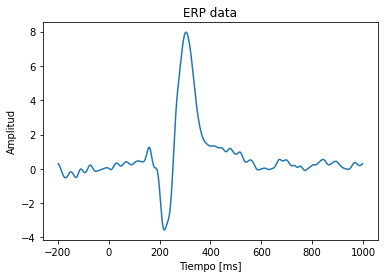

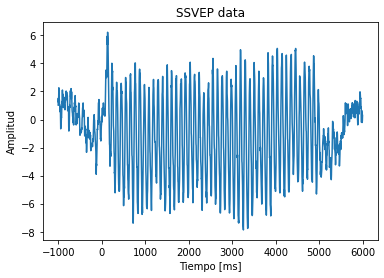

In [9]:
fig, ax = plt.subplots()
ax.plot(erp_time, erp)
ax.set_title('ERP data')
ax.set_xlabel('Tiempo [ms]')
ax.set_ylabel('Amplitud')
fig.savefig('fig/q2_erp_mean.png')

fig, ax = plt.subplots()
ax.plot(ssvep_time, ssvep)
ax.set_title('SSVEP data')
ax.set_xlabel('Tiempo [ms]')
ax.set_ylabel('Amplitud')
fig.savefig('fig/q2_ssvep_mean.png')

In [10]:
# Welch method
def welch(data, t, fs, win_size):
    win_size = int(win_size)

    ff = fftfreq(win_size, 1 / fs)[:win_size // 2]
    k = 0
    
    mean_spec = np.zeros(int(win_size / 2))
    mean_signal = np.zeros(win_size)
    n_overlap = 0
    
    win = np.hanning(win_size)

    while k + win_size < t.shape[0] - 1:        
        xf = fft(win * data[k : k + win_size])[:win_size // 2]
#         fft_arr.append(xf)
        mean_spec += np.abs(xf)

        k += int(win_size / 2)
        n_overlap += 1
        
    mxf = 2 / win_size * mean_spec / n_overlap
    
    return ff, mxf

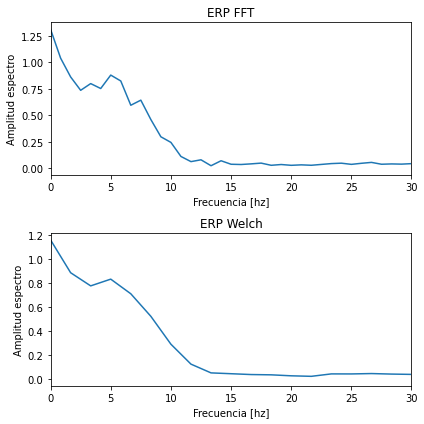

In [11]:
erp_fft = fft(erp)[:erp_N // 2]
erp_ff = fftfreq(erp_N, 1 / erp_fs)[:erp_N // 2]

win_size = erp_N / 2
erp_welch = welch(erp, erp_time, erp_fs, win_size)

fig, ax = plt.subplots(2, figsize=(6, 6))
ax[0].plot(erp_ff, 2 / erp_N * np.abs(erp_fft))
ax[0].set_xlim([0, 30])
ax[0].set_title('ERP FFT')
ax[0].set_xlabel('Frecuencia [hz]')
ax[0].set_ylabel('Amplitud espectro')

ax[1].plot(erp_welch[0], erp_welch[1])
ax[1].set_xlim([0, 30])
ax[1].set_title('ERP Welch')
ax[1].set_xlabel('Frecuencia [hz]')
ax[1].set_ylabel('Amplitud espectro')

fig.tight_layout()
fig.savefig('fig/erp_welch.png')

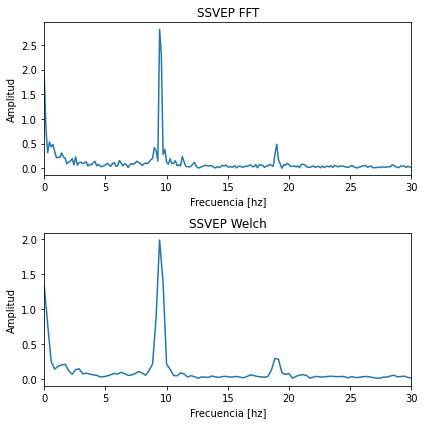

In [12]:
ssvep_fft = fft(ssvep)[:ssvep_N // 2]
ssvep_ff = fftfreq(ssvep_N, 1 / ssvep_fs)[:ssvep_N // 2]

win_size = ssvep_N / 2
ssvep_welch = welch(ssvep, ssvep_time, ssvep_fs, win_size)

fig, ax = plt.subplots(2, figsize=(6, 6))
ax[0].plot(ssvep_ff, 2 / ssvep_N * np.abs(ssvep_fft))
ax[0].set_xlim([0, 30])
ax[0].set_title('SSVEP FFT')
ax[0].set_xlabel('Frecuencia [hz]')
ax[0].set_ylabel('Amplitud')

ax[1].plot(ssvep_welch[0], ssvep_welch[1])
ax[1].set_xlim([0, 30])
ax[1].set_title('SSVEP Welch')
ax[1].set_xlabel('Frecuencia [hz]')
ax[1].set_ylabel('Amplitud')

fig.tight_layout()
fig.savefig('fig/erp_fft.png')

In [181]:
def signaltonoise(a, axis=0, ddof=0, filt=None):
    if filt is not None:
        p_signal = np.sqrt(np.mean(a[filt] ** 2))
        p_noise = np.sqrt(np.mean(a[~filt] ** 2))
        
        return(p_signal / p_noise)
    
    a = np.asanyarray(a)
    m = a.mean(axis) ** 2
    sd = a.std(axis=axis, ddof=ddof) ** 2
    return np.where(sd == 0, 0, m / sd)

def sort_by_snr(data, filt=None):
    arr = list(data)
    arr.sort(key=lambda x: signaltonoise(x, filt=filt), reverse=True)
    return np.array(arr)

def sort_by_var(data):
    arr = list(data)
    arr.sort(key=lambda x: np.var(x))
    return np.array(arr)

75/116


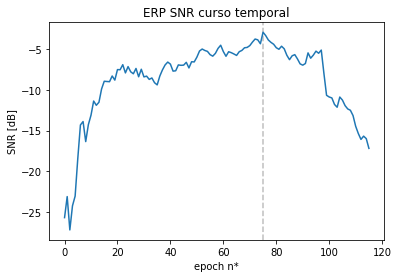

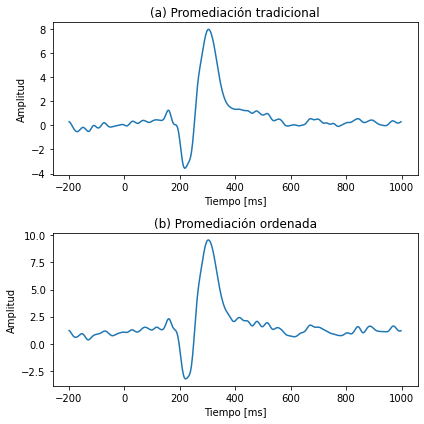

In [186]:
erp_signal_filt = (erp_time > 100) * (erp_time < 400)

s_erp_arr = sort_by_snr(erp_arr, erp_signal_filt)
s_erp_var = np.var(s_erp_arr, axis=0)

s_erp_snr = np.zeros(s_erp_arr.shape[0])
s_erp_rms = np.zeros(s_erp_arr.shape[0])

m_erp = np.zeros(s_erp_arr.shape)

for i in range(s_erp_arr.shape[0]):
    m_erp[i] = np.mean(s_erp_arr[:i + 1], axis=0)
    s_erp_snr[i] = signaltonoise(m_erp[i])
    s_erp_rms[i] = np.sqrt(np.mean(m_erp[i] ** 2))
    
max_epoch = np.argmax(s_erp_snr)
print('{}/{}'.format(max_epoch, s_erp_snr.shape[0]))

fig, ax = plt.subplots()
ax.axvline(max_epoch, linestyle='--', color='tab:gray', alpha=0.5)
ax.plot(20 * np.log10(s_erp_snr))
ax.set_title('ERP SNR curso temporal')
ax.set_xlabel('epoch n*')
ax.set_ylabel('SNR [dB]')
fig.savefig('fig/q2_erp_ordered_snr.png')

fig, ax = plt.subplots(2, figsize=(6, 6))
ax[0].plot(erp_time, erp)
ax[0].set_title('(a) Promediación tradicional')
ax[0].set_xlabel('Tiempo [ms]')
ax[0].set_ylabel('Amplitud')

ax[1].plot(erp_time, m_erp[max_epoch])
ax[1].set_title('(b) Promediación ordenada')
ax[1].set_xlabel('Tiempo [ms]')
ax[1].set_ylabel('Amplitud')

fig.tight_layout()
fig.savefig('fig/q2_erp_mean_cmp.png')

31/45
6.223569152090285 -7.874478627575768 -0.9539347774711333
6.2487397353890834 -7.637062542300957 -1.0980345228541537
9.571428571428571


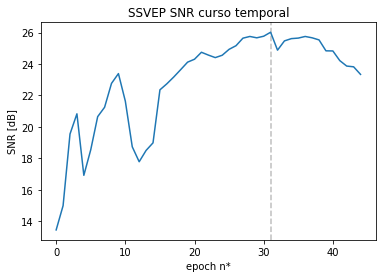

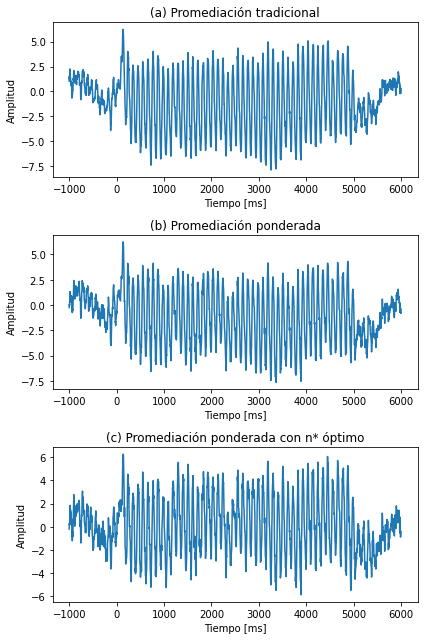

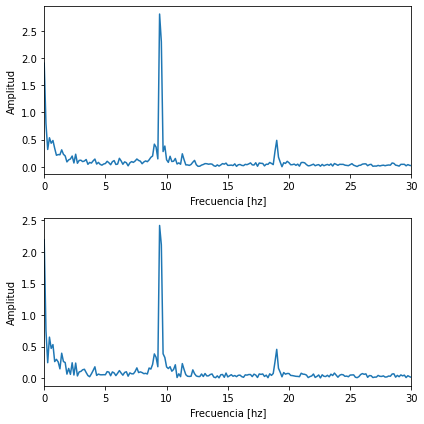

In [187]:
def spec_norm(spec, N):
    return 2 / N * np.abs(spec)

ssvep_fpeak = ssvep_ff[np.argmax(ssvep_fft)]
ssvep_filt = (ssvep_ff > ssvep_fpeak - 0.42)*(ssvep_ff < ssvep_fpeak + 0.42)

ssvep_snr = np.zeros(ssvep_arr.shape[0])
s_ssvep_snr = np.zeros(ssvep_arr.shape[0])
s_ssvep_rms = np.zeros(ssvep_arr.shape[0])

m_ssvep = np.zeros(ssvep_arr.shape)

for i in range(ssvep_arr.shape[0]):
    ssvep_snr[i] = signaltonoise(spec_norm(fft(ssvep_arr[i])[:ssvep_N // 2], ssvep_N), filt=ssvep_filt)
    w = 1 / (ssvep_snr[:i + 1] * np.sum(1 / ssvep_snr[:i + 1]))
    m_ssvep[i] = np.average(ssvep_arr[:i + 1], axis=0, weights=w)
    s_ssvep_snr[i] = signaltonoise(spec_norm(fft(m_ssvep[i])[:ssvep_N // 2], ssvep_N), filt=ssvep_filt)

max_epoch = np.argmax(s_ssvep_snr)
print('{}/{}'.format(max_epoch, s_ssvep_snr.shape[0]))
    
w_ssvep = m_ssvep[-1]
w_ssvep_fft = fft(m_ssvep[-1])[:ssvep_N // 2]

fig, ax = plt.subplots()
ax.axvline(max_epoch, linestyle='--', color='tab:gray', alpha=0.5)
ax.plot(20 * np.log10(s_ssvep_snr))
ax.set_title('SSVEP SNR curso temporal')
ax.set_xlabel('epoch n*')
ax.set_ylabel('SNR [dB]')
fig.savefig('fig/q2_ssvep_ordered_snr.png')

fig, ax = plt.subplots(3, figsize=(6, 9))
ax[0].plot(ssvep_time, ssvep)
ax[0].set_title('(a) Promediación tradicional')
ax[0].set_xlabel('Tiempo [ms]')
ax[0].set_ylabel('Amplitud')

ax[1].plot(ssvep_time, w_ssvep)
ax[1].set_title('(b) Promediación ponderada')
ax[1].set_xlabel('Tiempo [ms]')
ax[1].set_ylabel('Amplitud')

ax[2].plot(ssvep_time, m_ssvep[max_epoch])
ax[2].set_title('(c) Promediación ponderada con n* óptimo')
ax[2].set_xlabel('Tiempo [ms]')
ax[2].set_ylabel('Amplitud')

fig.tight_layout()
fig.savefig('fig/ssvep_mean_cmp.png')

print(np.max(ssvep), np.min(ssvep), np.mean(ssvep))
print(np.max(w_ssvep), np.min(w_ssvep), np.mean(w_ssvep))

fig, ax = plt.subplots(2, figsize=(6, 6))
ax[0].plot(ssvep_ff, spec_norm(ssvep_fft, ssvep_N))
ax[0].set_xlim([0, 30])
ax[0].set_xlabel('Frecuencia [hz]')
ax[0].set_ylabel('Amplitud')

ax[1].plot(ssvep_ff, spec_norm(w_ssvep_fft, ssvep_N))
ax[1].set_xlim([0, 30])
ax[1].set_xlabel('Frecuencia [hz]')
ax[1].set_ylabel('Amplitud')

print(ssvep_fpeak)

fig.tight_layout()
fig.savefig('fig/ssvep_spec_cmp.png')

In [111]:
ssvep_fpeak = ssvep_ff[np.argmax(ssvep_fft)]
ssvep_filt = (ssvep_ff > ssvep_fpeak - 0.42)*(ssvep_ff < ssvep_fpeak + 0.42)

def spec_norm(spec, N):
    return 2 / N * np.abs(spec)
    
def rms(data):
    return np.sqrt(np.mean(data ** 2))

rms(spec_norm(ssvep_fft[ssvep_filt], ssvep_N)) / rms(spec_norm(ssvep_fft[~ssvep_filt], ssvep_N))

18.11624972687256

In [92]:

ssvep_snr

array([ 4.70590906,  7.88954907,  4.22113918, 12.23654556,  3.26444921,
        9.64837445,  5.38627312,  9.39883026,  8.3096056 ,  9.84652416,
        2.85463367,  2.82306986,  5.72074255,  4.09147032,  7.44999282,
        1.59262224,  8.66186161,  5.70469953,  6.62968232,  5.13416251,
        8.72300465, 11.31336972,  4.157129  ,  4.12888211,  8.44065745,
        8.62824389,  5.41820272,  7.32127949,  8.48023357,  5.51871265,
        9.59757728,  6.84755925,  2.68478336,  6.28928029, 10.64212373,
        8.55409737,  8.52229043,  7.2984648 ,  7.41194957,  4.44417619,
        8.78315527,  4.39752535,  6.21091604,  6.52890938,  4.90572729])

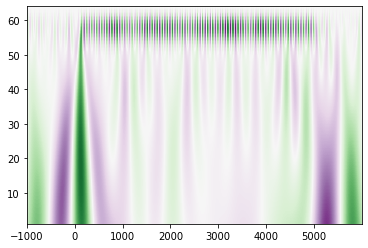

In [73]:
widths = np.arange(1, 64)
cwtmatr = cwt(w_ssvep, ricker, widths)

plt.imshow(cwtmatr, extent=[ssvep_time[0], ssvep_time[-1], 1, 64], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

plt.show()

In [59]:
np.real(cwtmatr)

array([[-0.69060552, -1.96132075, -1.77503171, ...,  0.48036147,
         0.30653401, -0.21214668],
       [-0.18618413,  0.35538599, -0.09929065, ...,  0.06701668,
        -0.10496201,  0.11193853],
       [-0.10615818,  0.8309241 , -0.00491835, ..., -0.48587333,
        -0.14505793,  0.37487167],
       ...,
       [ 1.44266678,  1.56631861,  1.63994251, ..., -1.17682728,
        -1.42808111, -1.63130508],
       [ 1.40422605,  1.52357393,  1.59813744, ..., -1.09483039,
        -1.34976415, -1.56177776],
       [ 1.37969208,  1.49324983,  1.56572713, ..., -1.01261882,
        -1.27038589, -1.48975155]])

## Código consultas

In [53]:
def check_data(arr):
    print('Mean: {:.2f}, STD: {:.2f}, var: {:.2f}, SNR: {:.2f}'.format(np.mean(arr),
                                                                       np.std(arr),
                                                                       np.var(arr),
                                                                       signaltonoise(arr, filt=erp_signal_filt)))
for i in range(5):
    check_data(s_erp_arr[i])

Mean: 0.83, STD: 3.62, var: 13.09, SNR: 3.48
Mean: 0.67, STD: 2.60, var: 6.76, SNR: 3.16
Mean: 0.17, STD: 3.22, var: 10.34, SNR: 2.94
Mean: 0.97, STD: 3.16, var: 9.98, SNR: 2.89
Mean: 0.85, STD: 2.93, var: 8.59, SNR: 2.82


In [14]:
for i in range(5):
    check_data(m_erp[i])

Mean: -19.50, STD: 2.40, var: 5.78, SNR: 65.84
Mean: -4.30, STD: 2.03, var: 4.14, SNR: 4.48
Mean: 0.46, STD: 1.74, var: 3.03, SNR: 0.07
Mean: -3.44, STD: 2.23, var: 4.95, SNR: 2.39
Mean: -1.22, STD: 2.20, var: 4.83, SNR: 0.31


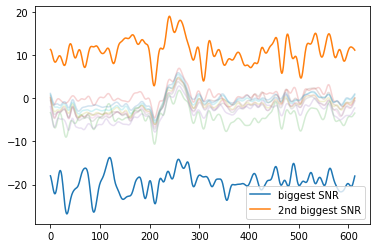

In [17]:
fig, ax = plt.subplots()

ax.plot(s_erp_arr[0], label='biggest SNR')
ax.plot(s_erp_arr[1], label='2nd biggest SNR')
for i in range(1, 10):
    ax.plot(m_erp[i], alpha=0.2)
ax.legend()
fig.savefig('first_snr.png')